c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📂 Đang load dataset: ../../data/metadata.csv
✅ Số mẫu: 3400 | Số nhãn: 3 | Nhãn: ['COVID-19', 'NORMAL', 'PNEUMONIA']
🧠 Dùng thiết bị: cpu
🚀 Đang tính toán BERT embeddings...


🔹Đang tạo embedding: 100%|██████████| 213/213 [00:35<00:00,  5.95it/s]


✅ Embeddings shape: (3400, 768)

==== 🧾 KẾT QUẢ (BERT + ML) ====

--- Logistic Regression ---
Accuracy: 0.8720588235294118
F1-weighted: 0.8718168401273034
              precision    recall  f1-score   support

    COVID-19     0.8419    0.9211    0.8797       266
      NORMAL     0.8920    0.8351    0.8626       188
   PNEUMONIA     0.8967    0.8451    0.8702       226

    accuracy                         0.8721       680
   macro avg     0.8769    0.8671    0.8708       680
weighted avg     0.8740    0.8721    0.8718       680

--- Random Forest ---
Accuracy: 0.875
F1-weighted: 0.8749274026204674
              precision    recall  f1-score   support

    COVID-19     0.8815    0.8947    0.8881       266
      NORMAL     0.8791    0.8511    0.8649       188
   PNEUMONIA     0.8640    0.8717    0.8678       226

    accuracy                         0.8750       680
   macro avg     0.8749    0.8725    0.8736       680
weighted avg     0.8750    0.8750    0.8749       680



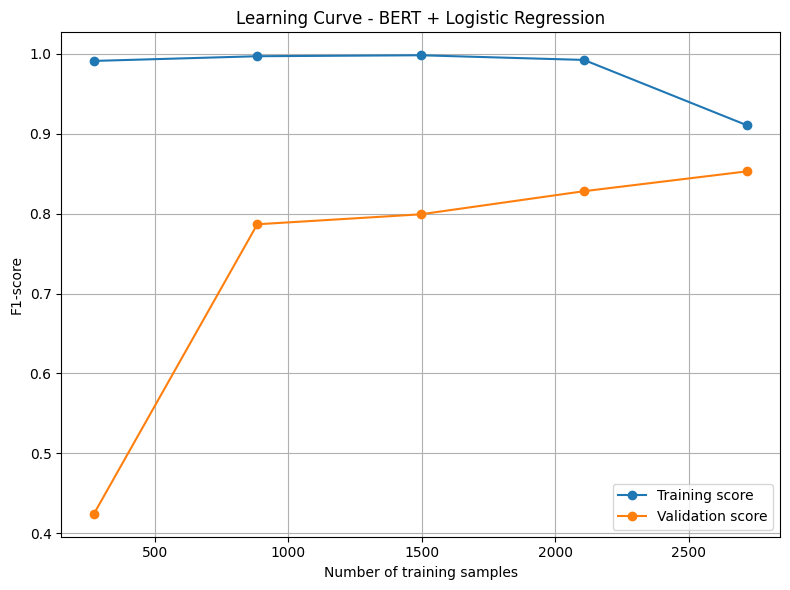

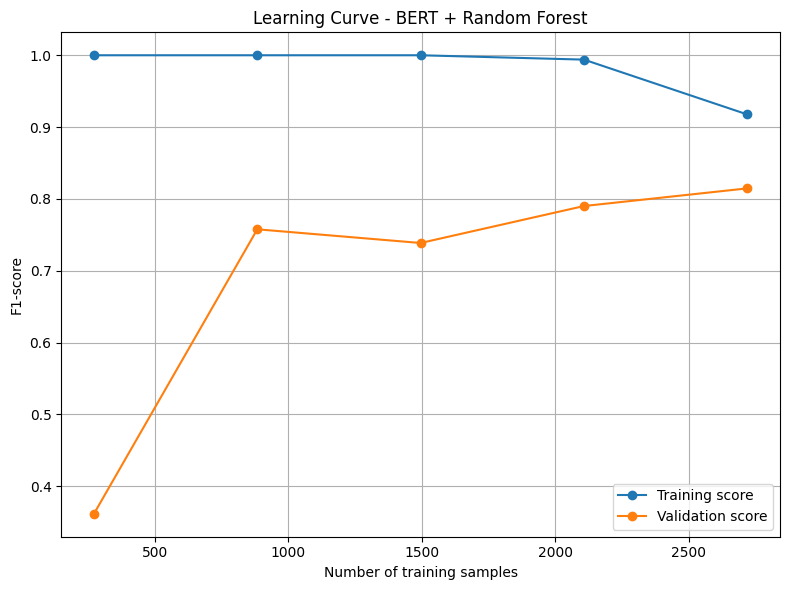

In [2]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, f1_score, classification_report

MODEL_NAME = "bert-base-uncased"  
BATCH_SIZE = 16
MAX_LEN = 64
TEST_SIZE = 0.2
RANDOM_STATE = 42

csv_path = "../../data/metadata.csv"
print(f"📂 Đang load dataset: {csv_path}")
df = pd.read_csv(csv_path)


texts = df["notes"].astype(str).tolist()
labels = df["finding"].astype("category").cat.codes
label_names = list(df["finding"].astype("category").cat.categories)

print(f"✅ Số mẫu: {len(texts)} | Số nhãn: {len(label_names)} | Nhãn: {label_names}")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
print(f"🧠 Dùng thiết bị: {device}")

def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X,
        y,
        cv=5,
        scoring="f1_weighted",
        train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=-1
    )

    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_mean, 'o-', label="Training score")
    plt.plot(train_sizes, val_mean, 'o-', label="Validation score")
    plt.title(title)
    plt.xlabel("Number of training samples")
    plt.ylabel("F1-score")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def get_bert_embeddings(texts, batch_size=BATCH_SIZE, max_len=MAX_LEN):
    """Tạo CLS embedding cho danh sách văn bản."""
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="🔹Đang tạo embedding"):
        batch = texts[i:i+batch_size]
        enc = tokenizer(
            batch,
            padding=True,
            truncation=True,
            return_tensors="pt",
            max_length=max_len
        ).to(device)

        with torch.no_grad():
            outputs = model(**enc)
            cls_embeds = outputs.last_hidden_state[:, 0, :]  # vector CLS
            embeddings.append(cls_embeds.cpu().numpy())

    return np.vstack(embeddings)

print("🚀 Đang tính toán BERT embeddings...")
X = get_bert_embeddings(texts)
y = labels.values
print(f"✅ Embeddings shape: {X.shape}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

results = {}
trained_models = {}

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
results["Logistic Regression"] = {
    "accuracy": accuracy_score(y_test, y_pred_lr),
    "f1": f1_score(y_test, y_pred_lr, average="weighted"),
    "report": classification_report(y_test, y_pred_lr, target_names=label_names, digits=4)
}
trained_models["Logistic Regression"] = lr

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
results["Random Forest"] = {
    "accuracy": accuracy_score(y_test, y_pred_rf),
    "f1": f1_score(y_test, y_pred_rf, average="weighted"),
    "report": classification_report(y_test, y_pred_rf, target_names=label_names, digits=4)
}
trained_models["Random Forest"] = rf

print("\n==== 🧾 KẾT QUẢ (BERT + ML) ====\n")
for name, res in results.items():
    print(f"--- {name} ---")
    print("Accuracy:", res["accuracy"])
    print("F1-weighted:", res["f1"])
    print(res["report"])

# ========== Logistic Regression ==========
lr_model = LogisticRegression(max_iter=1000)
plot_learning_curve(
    lr_model,
    X,
    y,
    "Learning Curve - BERT + Logistic Regression"
)

# ========== Random Forest ==========
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
plot_learning_curve(
    rf_model,
    X,
    y,
    "Learning Curve - BERT + Random Forest"
)
# save_dir = "../models"
# os.makedirs(save_dir, exist_ok=True)

# for name, model_obj in trained_models.items():
#     file_path = os.path.join(save_dir, f"bert_{name.replace(' ', '_').lower()}.pkl")
#     with open(file_path, "wb") as f:
#         pickle.dump(model_obj, f)
#     print(f"✅ Saved model: {file_path}")

# np.save(os.path.join(save_dir, "bert_embeddings.npy"), X)
# print("✅ Saved embeddings.")

# save_results_path = os.path.join(save_dir, "results_bert.json")
# with open(save_results_path, "w", encoding="utf-8") as f:
#     json.dump(results, f, indent=4, ensure_ascii=False)
# print(f"✅ Saved evaluation results to {save_results_path}")

# for name, model_obj in trained_models.items():
#     print(f"\n🔍 Model: {name}")
#     print("Classes learned:", model_obj.classes_)
#     print("Number of classes:", len(model_obj.classes_))


In [4]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm
from torch.optim import AdamW


# =========================
# CONFIG
# =========================
MODEL_NAME = "bert-base-uncased"
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 4
LR = 2e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =========================
# LOAD DATA
# =========================
df = pd.read_csv("../../data/metadata.csv")
texts = df["notes"].astype(str).tolist()
labels = df["finding"].astype("category").cat.codes
label_names = list(df["finding"].astype("category").cat.categories)
num_labels = len(label_names)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# =========================
# TOKENIZER
# =========================
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

train_enc = tokenize(train_texts)
val_enc = tokenize(val_texts)

# =========================
# DATASET
# =========================
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_enc, train_labels)
val_dataset   = TextDataset(val_enc, val_labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# =========================
# MODEL
# =========================
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
).to(DEVICE)

optimizer = AdamW(model.parameters(), lr=LR)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

# =========================
# TRAINING
# =========================
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} - Train loss: {total_loss / len(train_loader):.4f}")

    # ===== Validation =====
    model.eval()
    preds, true_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(batch["labels"].cpu().numpy())

    print("Accuracy:", accuracy_score(true_labels, preds))
    print("F1:", f1_score(true_labels, preds, average="weighted"))
    print(classification_report(true_labels, preds, target_names=label_names))

# # =========================
# # SAVE MODEL
# # =========================
# model.save_pretrained("./bert_finetuned")
# tokenizer.save_pretrained("./bert_finetuned")
# print("✅ Model saved!")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1:   0%|          | 0/170 [00:00<?, ?it/s]


ValueError: Target size (torch.Size([16])) must be the same as input size (torch.Size([16, 3]))

In [ ]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from torch.optim import AdamW
from tqdm import tqdm

# =========================
# CONFIG
# =========================
MODEL_NAME = "bert-base-uncased"
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 4
LR = 2e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =========================
# LOAD DATA
# =========================
df = pd.read_csv("../../data/metadata.csv")

texts = df["notes"].astype(str).tolist()
labels = df["finding"].astype("category").cat.codes
label_names = list(df["finding"].astype("category").cat.categories)
num_labels = len(label_names)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

# =========================
# TOKENIZER
# =========================
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

def tokenize(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)

# =========================
# DATASET
# =========================
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.reset_index(drop=True)

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# =========================
# MODEL
# =========================
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    problem_type="single_label_classification"
)

model.to(DEVICE)

optimizer = AdamW(model.parameters(), lr=LR)

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

# =========================
# TRAINING LOOP
# =========================
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        batch = {k: v.to(DEVICE) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"\nEpoch {epoch+1} | Train loss: {avg_loss:.4f}")

    # ===== VALIDATION =====
    model.eval()
    preds, golds = [], []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits

            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            golds.extend(batch["labels"].cpu().numpy())

    print("Accuracy:", accuracy_score(golds, preds))
    print("F1-score:", f1_score(golds, preds, average="weighted"))
    print(classification_report(golds, preds, target_names=label_names))

# =========================
# SAVE MODEL
# =========================
model.save_pretrained("./bert_finetuned")
tokenizer.save_pretrained("./bert_finetuned")
print("✅ Model saved successfully!")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 170/170 [03:13<00:00,  1.14s/it]



Epoch 1 | Train loss: 0.5955
Accuracy: 0.8588235294117647
F1-score: 0.8592955425405685
              precision    recall  f1-score   support

    COVID-19       0.81      0.90      0.86       266
      NORMAL       0.95      0.82      0.88       188
   PNEUMONIA       0.85      0.84      0.84       226

    accuracy                           0.86       680
   macro avg       0.87      0.85      0.86       680
weighted avg       0.86      0.86      0.86       680



Epoch 2:  74%|███████▎  | 125/170 [02:28<00:53,  1.20s/it]